<span style="font-size:30pt;font-weight:bold">Home Credit Python Scoring Workflow v.0.7.0</font>

**Copyright:**

© 2017-2018, Pavel Sůva, Marek Teller, Martin Kotek, Jan Zeller, Marek Mukenšnabl, Kirill Odintsov, Jan Hynek, Elena Kuchina and Home Credit & Finance Bank Limited Liability Company, Moscow, Russia – all rights reserved

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the [License](http://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


**Contributors:**
- Pavel Sůva (HCI Research & Development)
- Sergey Gerasimov (HCRU Scoring & Big Data)
- Valentina Kalenichenko (HCRU Scoring & Big Data)
- Marek Teller (HCI Research & Development)
- Martin Kotek (HCCN Risk Decision & Big Data)
- Jan Zeller
- Marek Mukenšnabl (HCI Research & Development)
- Anatoliy Glushenko (HCRU Scoring & Big Data)
- Kirill Odintsov (HCI Research & Development)
- Jan Hynek (HCI Research & Development)
- Elena Kuchina (HCI Research & Development)
- Dmitry Gorev (HCRU Scoring & Big Data)

# Import packages

## List of packages
- `time`, datetime - ability to get current time for logs
- `math` - basic mathematical functions (as logarithm etc.))
- `random` - generate random selection from probability distributions
- `NumPy` - for scientific, mathematical, numerical calculations
- `Scipy` - for clustering and correlation calculations
- `Pandas` - for efficient work with large data structures (you need pandas **version 0.23 or higher**)
- `cx_Oracle` and sqlalchemy - for loading data from Oracle database (DWH etc.)
- `scikit`-learn - all important machine learning (and statistical) algorithms used for training the models
- `matplotlib` - for plotting the charts
- `seaborn` - for statistical visualisations
- `os` - for setting output paths for generated image files
- `pickle` - to save models to external files
- `tqdm` - intelligent progress bar
- `tkinter` - for interactive Interactions tool GUI
- `xgboost` - gradient boosting used for feature selection before regression

**If any of these packages is missing, you have to install it from the Anaconda prompt using command *conda install packagename* where *packagename* is the name of the installed package.**

There is another package called *scoring*, which is distributed along with this workflow. **The folder *scoring* must be located in the same folder as this workflow for the package to be loaded correctly.** Alternatively, you can locate it somewhere else and then use *sys.path.insert()* to map this location.

## Other important prerequisites

For the grouping some **extensions for Jupyter must be installed and enabled before Jupyter is started and the notebook is loaded**. These extensions are Javascripts running in the browser, so it is necessary to have a compatibile browser. Generally, Chrome is OK, Internet Explorer 11 is NOT OK. To install the extensions, run this in your Anaconda prompt:

- `conda install ipywidgets`
- `jupyter nbextension enable --py --sys-prefix widgetsnbextension`
- `conda config --add channels conda-forge`
- `conda install qgrid` 
- `jupyter nbextension enable --py --sys-prefix qgrid`
- `conda install tqdm`

Please, make sure that qgrid library that you installed in this step is **verison 1.0.3 or higher**. 

To be able to connect to Oracle database (to get the data directly from your DWH) you need a compatibile Oracle driver to be installed on your computer. **With 64-bit Python, you need to have 64-bit Oracle driver installed.** Before you install the driver, you need to have Java 8 JDK (JRE is not enough) installed on your computer.

In [1]:
import time
import datetime
import operator
import math
import random
import numpy as np
import pandas as pd
# import cx_Oracle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import pickle
import gc
from tqdm import tqdm_notebook as tqdm
#import tkinter
#import xgboost as xgb

import sys

sys.path.append(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\Scoring Workflow")
import scoring
#import importlib
#importlib.reload(scoring)

# import warnings
# warnings.filterwarnings('ignore')
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\Vodafone Score WOE")

Set general technical parameters and paths.

In [2]:
sns.set()
%matplotlib inline
%config InlineBackend.close_figures=True
from IPython.display import display, Markdown
pd.options.display.max_columns = None
pd.options.display.max_rows = 15
output_folder = 'documentation'

if not os.path.exists(output_folder): os.makedirs(output_folder)
if not os.path.exists(output_folder+'/performance'): os.makedirs(output_folder+'/performance')
if not os.path.exists(output_folder+'/predictors'): os.makedirs(output_folder+'/predictors')
if not os.path.exists(output_folder+'/stability'): os.makedirs(output_folder+'/stability')
if not os.path.exists(output_folder+'/stability_short'): os.makedirs(output_folder+'/stability_short')
if not os.path.exists(output_folder+'/analysis'): os.makedirs(output_folder+'/analysis')
if not os.path.exists(output_folder+'/model'): os.makedirs(output_folder+'/model')
if not os.path.exists(output_folder+'/nan_share'): os.makedirs(output_folder+'/nan_share')
scoring.check_version('0.7.0')

# Input data

## Import data
Importing data from a CSV file. It is important to set the following parameters:

encoding: usually 'utf-8' or windows-xxxx on Windows machines, where xxxx is 1250 for Central Europe, 1251 for Cyrilic etc.
sep: separator of columns in the file
decimal: decimal dot or coma
index_col: which columns is used as index - should be the unique credit case identifier

**Defining NA values:** In different datasets, there can be different values to be considered *N/A*. By default, we set only blank fields to be considered *N/A*, however you might want to change it and add values like *'NA'*, *'NAN'*, *'null'* to be also considered *N/A*. User parameter `na_values` for this.

In [3]:
from scoring import db
data = db.read_csv(os.getcwd()+r'\Data Files\vodafone_woe_base_exi.CSV', sep = ',', decimal = '.',
                   optimize_types=True, encoding = 'utf-8', index_col = 'SKP_CREDIT_CASE', low_memory = False,
                   keep_default_na = False, na_values = [''])
print('Data loaded on',datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Data loaded on 2020-12-13 19:16:34


The data need to have index column which has unique value per each row. If not, it can cause some problems later. Run this to deal with such rows:

In [5]:
data= data[["DATE_DECISION","CREDIT_SCORE","RISK_FSTPD30"]]

In [5]:
# data.info()

In [6]:
#Option 1: remove rows with duplicated index
data=data[~data.index.duplicated(keep='first')]

#Option 2: reset index
#data.reset_index(inplace=True)

Optionally the data can be loaded also from a database. The function read_sql uses cache, so the data don't have to be downloaded from the database repeatedly. The cache will be located in a new folder called **db_cache**.

In [7]:
# from sqlalchemy import create_engine
#engine = create_engine('oracle://PAVELS[GP_HQ_RISK]:xxx@(DESCRIPTION=(ADDRESS=(PROTOCOL=TCP)(HOST=DBDWHRU.HOMECREDIT.RU)(PORT=1521))(CONNECT_DATA=(SERVICE_NAME=DWHRU)))', echo=False)

In [8]:
#from scoring.db import read_sql
#ru_data = read_sql('select * from owner_dwh.f_application_tt where rownum<11',engine, index_col = 'sk_application')
#print('Data loaded on',datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

If you need to download data from the database again (and not from cache), use the parameter refresh:

In [9]:
#from scoring.db import read_sql
#data = read_sql('select * from owner_dwh.f_application_base_tt where rownum=1',engine, index_col = 'skp_application',refresh=True)
#print('Data loaded on',datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

In [10]:
print('Number of rows:',data.shape[0])
print('Number of columns:',data.shape[1])

Number of rows: 1079847
Number of columns: 3


## Metadata definitions
Assigning ID column, target column, time column and month column. The month column don't have to exist in the dataset, it will be created later in this workflow.

In [4]:
### THESE COLUMNS MUST BE INCLUDED IN THE DATA SET ###
#name of the target column
col_target = "RISK_FSTPD30"
#name of the time column
col_time = "DATE_DECISION"

### THESE COLUMNS DON'T HAVE TO BE INCLUDED IN THE DATA SET AND ARE CREATED AUTOMATICALLY LATER ###
#name of the base column
col_base = "BASE"
#name of the month column
col_month = "MONTH"
#name of the day column
col_day = "DAY"
#name of the weight column - CURRENTLY COMMENTED OUT BECAUSE OF REASONS MENTIONED LATER
col_weight = 'WEIGHT'
#name of the reject column - only use if exists in your data, used for reject inference analysis
col_reject = 'REJECTED'

In [7]:
pd.DataFrame.from_records([['col_time',col_time],['col_month',col_month],['col_day',col_day],['col_target',col_target],['col_base',col_base]]) \
.to_csv(output_folder+'/model/metadata.csv',index=0,header=None)

data[col_target] = data[col_target].astype(np.float)

If you don't have base column in your data set, the following code adds it (based on if target is filled).

In [8]:
if col_base not in data:
    data[col_base] = 0
    data.loc[data[col_target]==0,col_base] = 1
    data.loc[data[col_target]==1,col_base] = 1
    print('Column',col_base,'added/modified. Number of columns:',data.shape[1])
else:
    print('Column',col_base,'already exists.')

Column BASE added/modified. Number of columns: 4


If you don't have weight column in your data set, the following code adds it, with value = 1 for each row. **The weights are currently supported by Data Exploration, Interactive Grouping and Model Selection (L1 regression and Stepwise) classes, but not by all functions in the workflow. This is why they are commented out now (can be uncommented by the user).**

In [14]:
# if col_weight not in data:
#    data[col_weight] = 1
#    print('Column',col_weight,'added/modified. Number of columns:',data.shape[1])
# else:
#    print('Column',col_weight,'already exists.')

Create the month and day column from the time column is doing the following
- take the time column and tell in which format the time is saved in - **you need to specify this in variable *dtime_input_format*** (see https://docs.python.org/3/library/time.html#time.strftime for reference)
- strip the format just to year, month, day string
- convert the string to number
- the new column will be added to the dataset as day
- truncate this column to just year and month and add it to dataset as month

In [9]:
dtime_input_format = '%d-%m-%y'

In [10]:
data[col_day] = list(pd.to_numeric(pd.to_datetime(data[col_time], format=dtime_input_format).dt.strftime('%Y%m%d')))
data[col_month] = data[col_day].apply(lambda x: math.trunc(x/100))
print('Columns',col_day,'and',col_month,'added/modified. Number of columns:',data.shape[1])

Columns DAY and MONTH added/modified. Number of columns: 6


In [11]:
data.head(5)

,DATE_DECISION,CREDIT_SCORE,RISK_FSTPD30,BASE,DAY,MONTH
SKP_CREDIT_CASE,,,,,,
249824251,28-08-19,NaN,1.0,1,20190828,201908
249824362,28-08-19,NaN,0.0,1,20190828,201908
249824367,28-08-19,NaN,0.0,1,20190828,201908
249824372,28-08-19,NaN,0.0,1,20190828,201908
249824479,28-08-19,NaN,0.0,1,20190828,201908


Load the predictors list from a csv file. The csv should have just one column, without any header, containing the name of the variables that should be used as predictors.

Support for boolean predictors in **not** currently implemented. Convert boolean predictors to object to use them.

`s = s.apply(lambda value: str(value) if not np.isnan(value) else value).astype('object')`

In [18]:
data.columns

Index(['DATE_DECISION', 'CREDIT_SCORE', 'RISK_FSTPD30', 'BASE', 'DAY',
       'MONTH'],
      dtype='object')

In [19]:
from scoring.data_manipulation import split_predictors_bytype

cols_pred = list(['CREDIT_SCORE'])

cols_pred, cols_pred_num, cols_pred_cat = split_predictors_bytype(data,
                                                                  pred_list=cols_pred,
                                                                  non_pred_list= [],
                                                                  optimize_types=True,
                                                                  convert_bool2int=True)

List of numerical predictors: [1]

CREDIT_SCORE                        float64

List of categorical predictors: [0]



**Please check if all predictors were categorized correctly.** 
`Category` dtype is now used for categorical columns for memory efficiency. This means it will not be editable as *string*. If you need to edit values of a categorical column convert it to *string* using this syntax:

`data['Column name'] = data['Column name'].astype(str)`

## Data exploration

In [20]:
descrip = data.describe(include='all').transpose()
pd.options.display.max_rows = 1000
display(descrip)
pd.options.display.max_rows = 15

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DATE_DECISION,1079847,405,25-10-19,11509,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CREDIT_SCORE,178192,NaN,NaN,NaN,0.207898,0.79949,0.001633,0.0123146,0.0201425,0.0334667,4.16912
RISK_FSTPD30,1.07985e+06,NaN,NaN,NaN,0.0119387,0.10861,0,0,0,0,1
BASE,1.07985e+06,NaN,NaN,NaN,1,0,1,1,1,1,1
DAY,1.07985e+06,NaN,NaN,NaN,2.01964e+07,4695.49,2.01908e+07,2.01911e+07,2.02001e+07,2.02006e+07,2.0201e+07
MONTH,1.07985e+06,NaN,NaN,NaN,201964,46.9586,201908,201911,202001,202006,202010


**explore_numerical** and **explore_categorical** functions give graphical data exploratory analyses. They can also output into html files. You just need to specify the folder for output.

If you want the detailed legacy HTML output (v0.4.3) comment-out the cell below

These functions analyze only the part of data where target is not null even if it is not explicitly specified.

In [21]:
data[cols_pred].shape

(1079847, 1)

In [23]:
from scoring.data_exploration import explore_categorical, explore_numerical, join_explorations

explored_columns = list()
for name, column in tqdm(data[cols_pred].iloc[0:200000,].iteritems(), total=len(cols_pred), leave=False):
    if name in cols_pred_num[:]:
        if (column.count() > 0) and (column.max() != column.min()):
            explore_numerical(column, data[col_target].iloc[0:200000,], weightCol=None, htmlOut=True, ntbOut=False, outFolder='exp')
            explored_columns.append(name)
    if name in cols_pred_cat[:]:
        if (column.count() > 0) and (len(set(column.unique()) - {np.nan}) > 1):
            explore_categorical(column, data[col_target].iloc[0:200000,], weightCol=None, htmlOut=True, ntbOut=False, outFolder='exp')
            explored_columns.append(name)
            
#comment out the line below if you didn't generate html files in this cell        
join_explorations(explored_columns, filename = '_exploration.html', outFolder='exp', weighted=False)  

**explore_df** function creates a simple text report about the important variable. The report can be then printed either to the screen or to a file.

In the following code, only such part of data that has col_base = 1 is analyzed. You can remove the condition if you wish.

In [24]:
from scoring.data_exploration import explore_df
st = explore_df(data[data[col_base]==1],col_month,col_target,cols_pred)
print(st, file=open("data_exp.txt", "w", encoding='utf-8'))
# print(st)

**Default rate in time**: Simple visualisation of observation count and default rate in time

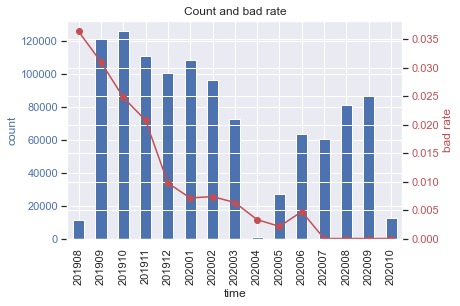

In [25]:
from scoring.plot import plot_dataset
plot_dataset(data,
             month_col=col_month,
             def_col=col_target,
             title='Count and bad rate',
             base_col=col_base,
             #weightCol=col_weight,
             savepath=output_folder+'/analysis/',
             zeroYlim=True)

**NaN share by month** for each variable in dataset:

Calculating NaN shares...
Making images...


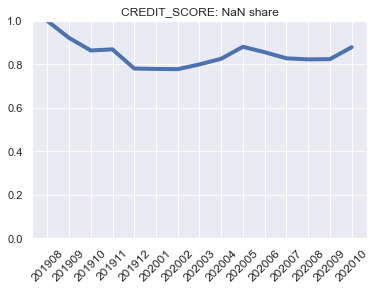

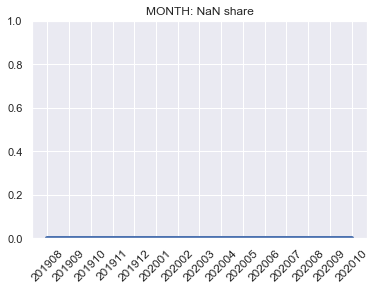

MONTH,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010
CREDIT_SCORE,0.999,0.921,0.863,0.868,0.78,0.778,0.777,0.799,0.825,0.88,0.855,0.827,0.822,0.823,0.878
MONTH,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000


In [26]:
from scoring.data_exploration import nan_share_development

nan_table = nan_share_development(data[cols_pred + [col_month]], col_month, 
                                  make_images=True, show_images=True, output_path=output_folder+'/nan_share/')
display(nan_table)

## Data split

- Split data into five parts (in time training, in time validation, in time test, out of time, historical out of time)
- Adds a new column indicating to which part the observations belong
- The *splitting_points* (first date of train and first date of out of time sample) can be adjusted (there can be any number of such splitting points) - it should correspond to values of column specified by *time_column* parameter
- For each time split, you can create multiple random splits (i.e. train/valid/test), the ratio of sizes of these splits is set by parameter *sample_sizes*
- The random splits can be stratified by multiple variables, which are specified in a list - argument to *stratify_by_columns* parameter
- Set the random seed so the results are replicable

In [12]:
from scoring.data_manipulation import data_sample_time_split

data['data_type'] = data_sample_time_split(data, 
                           time_column = col_month,
                           splitting_points = [201909, 201911],
                           sample_sizes = [[ 1    ],[ 0.4   , 0.3   , 0.3  ],[ 1   ]],
                           sample_names = [['hoot'],['train','valid','test'],['oot']],
                           stratify_by_columns = [col_month,col_target],
                           random_seed = 1234)

hoot    11,265 rows
train   98,824 rows
valid   74,118 rows
test    74,118 rows
oot     821,522 rows


Masks: boolean vectors corresponding to rows in the datasets. True if an row is observable and its data type belongs to given sample.

In [13]:
train_mask = (data['data_type'] == 'train') & (data[col_base] == 1) 
valid_mask = (data['data_type'] == 'valid') & (data[col_base] == 1) 
test_mask = (data['data_type'] == 'test') & (data[col_base] == 1) 
oot_mask = (data['data_type'] == 'oot') & (data[col_base] == 1) 
hoot_mask = (data['data_type'] == 'hoot') & (data[col_base] == 1) 

In [15]:
type(train_mask)

pandas.core.series.Series

Data summary (number of defaults, number in base, number of observations, default rate) by month and by sample

In [29]:
data_summary = data.groupby([col_month,'data_type']).aggregate({
    col_target:'sum',col_base:['sum','count']
})
data_summary.columns = [col_target,col_base,'Rows']
data_summary[col_target+' rate'] = data_summary[col_target]/data_summary[col_base]
display(data_summary)

data_summary = data_summary.reset_index(level='data_type').pivot(columns='data_type')
display(data_summary)
data_summary.to_csv(output_folder+'/analysis/summary.csv')

RISK_FSTPD30   BASE   Rows  RISK_FSTPD30 rate
MONTH  data_type                                               
201908 hoot              410.0  11265  11265           0.036396
201909 test             1129.0  36392  36392           0.031023
       train            1506.0  48523  48523           0.031037
       valid            1130.0  36392  36392           0.031051
201910 test              937.0  37726  37726           0.024837
...                        ...    ...    ...                ...
202006 oot               302.0  63767  63767           0.004736
202007 oot                 0.0  60518  60518           0.000000
202008 oot                 0.0  81098  81098           0.000000
202009 oot                 0.0  86539  86539           0.000000
202010 oot                 0.0  12216  12216           0.000000

[19 rows x 4 columns]

RISK_FSTPD30                                     BASE            \
data_type         hoot     oot    test   train   valid     hoot       oot   
MONTH                                                                       
201908           410.0     NaN     NaN     NaN     NaN  11265.0       NaN   
201909             NaN     NaN  1129.0  1506.0  1130.0      NaN       NaN   
201910             NaN     NaN   937.0  1248.0   936.0      NaN       NaN   
201911             NaN  2306.0     NaN     NaN     NaN      NaN  111003.0   
201912             NaN   984.0     NaN     NaN     NaN      NaN  100831.0   
202001             NaN   771.0     NaN     NaN     NaN      NaN  108151.0   
202002             NaN   712.0     NaN     NaN     NaN      NaN   96366.0   
202003             NaN   459.0     NaN     NaN     NaN      NaN   72606.0   
202004             NaN     4.0     NaN     NaN     NaN      NaN    1205.0   
202005             NaN    58.0     NaN     NaN     NaN      NaN   27222.0   
202006             NaN   302.0     NaN     NaN     NaN      NaN   63767.0   
202007             NaN     0.0     NaN     NaN     NaN      NaN   60518.0   
202008             NaN     0.0     NaN     NaN     NaN      NaN   81098.0   
202009             NaN     0.0     NaN     NaN     NaN      NaN   86539.0   
202010             NaN     0.0     NaN     NaN     NaN      NaN   12216.0   

                                         Rows                              \
data_type     test    train    valid     hoot       oot     test    train   
MONTH                                                                       
201908         NaN      NaN      NaN  11265.0       NaN      NaN      NaN   
201909     36392.0  48523.0  36392.0      NaN       NaN  36392.0  48523.0   
201910     37726.0  50301.0  37726.0      NaN       NaN  37726.0  50301.0   
201911         NaN      NaN      NaN      NaN  111003.0      NaN      NaN   
201912         NaN      NaN      NaN      NaN  100831.0      NaN      NaN   
202001         NaN      NaN      NaN      NaN  108151.0      NaN      NaN   
202002         NaN      NaN      NaN      NaN   96366.0      NaN      NaN   
202003         NaN      NaN      NaN      NaN   72606.0      NaN      NaN   
202004         NaN      NaN      NaN      NaN    1205.0      NaN      NaN   
202005         NaN      NaN      NaN      NaN   27222.0      NaN      NaN   
202006         NaN      NaN      NaN      NaN   63767.0      NaN      NaN   
202007         NaN      NaN      NaN      NaN   60518.0      NaN      NaN   
202008         NaN      NaN      NaN      NaN   81098.0      NaN      NaN   
202009         NaN      NaN      NaN      NaN   86539.0      NaN      NaN   
202010         NaN      NaN      NaN      NaN   12216.0      NaN      NaN   

                   RISK_FSTPD30 rate                                          
data_type    valid              hoot       oot      test     train     valid  
MONTH                                                                         
201908         NaN          0.036396       NaN       NaN       NaN       NaN  
201909     36392.0               NaN       NaN  0.031023  0.031037  0.031051  
201910     37726.0               NaN       NaN  0.024837  0.024811  0.024810  
201911         NaN               NaN  0.020774       NaN       NaN       NaN  
201912         NaN               NaN  0.009759       NaN       NaN       NaN  
202001         NaN               NaN  0.007129       NaN       NaN       NaN  
202002         NaN               NaN  0.007388       NaN       NaN       NaN  
202003         NaN               NaN  0.006322       NaN       NaN       NaN  
202004         NaN               NaN  0.003320       NaN       NaN       NaN  
202005         NaN               NaN  0.002131       NaN       NaN       NaN  
202006         NaN               NaN  0.004736       NaN       NaN       NaN  
202007         NaN               NaN  0.000000       NaN       NaN       NaN  
202008         NaN               NaN  0.000000     

# Grouping and WOE transformation of variables

Don't use such variables which have only 0 or 1 unique levels. Grouping doesn't work for them.

In [30]:
cols_del = list()
for name, column in tqdm(data[train_mask][cols_pred].iteritems(), total=len(cols_pred)):
    if name in cols_pred_num:
        if (column.count() == 0) or (column.max() == column.min()):
            cols_del.append(name)
            cols_pred_num.remove(name)
    if name in cols_pred_cat:
        if (column.count() == 0) or (len(set(column.unique()) - {np.nan}) <= 1):
            cols_del.append(name)
            cols_pred_cat.remove(name)
            
cols_pred = cols_pred_num + cols_pred_cat

if len(cols_del) > 0:
    print('Variables', cols_del, 'will not be further used as they have only 1 unique level.')
else:
    print('All predictors have more than 1 unique level.')
del cols_del

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



All predictors have more than 1 unique level.


In [31]:
for name, column in tqdm(data[cols_pred_num].iteritems(), total=len(cols_pred_num), leave=False):
    if np.any(np.isinf(column.values)):
            print('{} containes INF values. Please deal with them.'.format(name))

# data['predictor'].replace(to_replace=np.inf, value=<good idea>, inplace=True)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


There are two options how to group your variables. 
1. Automatic grouping groups the variables using a decision tree. User can't change the grouping in any interactive way. The grouping can be saved into external file using its method *save()*. 
2. Interactive grouping is suitable for smaller numbers of variables. User can control which values of each varible will enter which group. The grouping can be saved into external file using the interactive environment.

## Automatic Grouping
The grouping uses decision tree algorithm and the grouping is supervised based on the target variable. In the following code:

A new instance of **Grouping** class is created. There are two important parameters:
 - *colums*: list of numerical columns to be grouped
 - *cat_columns*: list of categorical columns to be grouped
 - *group_count*: (maximal) number of final groups of each variable
 - *min_samples*: minimal number of observations in each group of each numerical variable
 - *min_samples_cat*: minimal number of observations in each group of each categorical variable

In [32]:
from scoring.grouping import Grouping

grouping = Grouping(columns = sorted(cols_pred_num),
                    cat_columns = sorted(cols_pred_cat),
                    group_count=3, 
                    min_samples=1000, 
                    min_samples_cat=1000)

In [33]:
grouping.fit(data[train_mask][cols_pred],
             data[train_mask][col_target],
          #   w=data[train_mask][col_weight],
            progress_bar=True, category_limit=10000);

# if len(grouping.bins_data_) > 0:
#     for v,g in grouping.bins_data_.items():
#         print('Variable:',v)
#         print('Bins:',g['bins'])
#         print('WOEs:',g['woes'])
#         if v in cols_pred_num:
#             print('nan WOE:',g['nan_woe'])
#         if v in cols_pred_cat:
#             print('WOE for unknown values:',g['unknown_woe'])
#         print()

Save grouping to an external file.

In [34]:
model_filename = 'myGrouping'
grouping.save(model_filename)
# print('Grouping data saved to file',model_filename)

'Grouping saved on 2020-10-07 13:32:37 to file myGrouping'

## Interactive Grouping (beta)
**This is a beta version which means it should work well in most cases but sometimes it can be unstable. Please inform us about any issues you find**

**KNOWN ISSUES:**
- If zoom level in the web browser is set to something else than 100%, the charts might get broken.

A new instance of **InteractiveGrouping** class is created. There are two important parameters:
 - *colums*: list of numerical columns to be grouped
 - *cat_columns*: list of categorical columns to be grouped
 - *group_count*: (maximal) number of final groups of each variable
 - *min_samples*: minimal number of observations in each group of each numerical variable
 - *min_samples_cat*: minimal number of observations in each group of each categorical variable

In [35]:
USE_INTERATIVE_GROUPING = False

In [36]:
if USE_INTERATIVE_GROUPING:
    from scoring.grouping import Grouping, InteractiveGrouping

    grouping = InteractiveGrouping(columns = sorted(cols_pred_num),
                                   cat_columns = sorted(cols_pred_cat),
                                   group_count=4,
                                   min_samples=100, 
                                   min_samples_cat=100,
                                   woe_smooth_coef=0.001)

Then you open the interactive environment using **display** method. The important parameters are:
 - *train_t*: training dataset the grouping should be based on
 - *colums*: list of numerical columns to be grouped and displayed
 - *cat_columns*: list of categorical columns to be grouped and displayed
 - *target_column*: as the grouping is supervised and calculates WOE values, you need to specify the target column name
 - *w_column*: vector of weights of obervation (if not filled, grouping behaves as there are equal weights)
 - *filename*: use only if you want to load a grouping that you created and saved previously
 - *group_count*: (maximal) number of final groups of each variable
 - *min_samples*: minimal number of observations in each group of each numerical variable
 - *min_samples_cat*: minimal number of observations in each group of each categorical variable

In the interactive environment, you can see four sections. From top to bottom:
- **Chart section**: 
 - For **numerical variables**, there is chart with equifrequncy fine classing (observations as bars, default rate as line), equidistant fine classing and the final groups.
 - For **categorical varibles** there is chart with each of the original categorical values and a chart with the final groups.
- **Variable section**: here you can choose tab with varible which you want to edit. 
 - For **numerical variables**, the tab contains of the borders of the final groups. You can edit these borders, add new with [+] button and remove them with [-] button. You can also manually set WOE for nulls. There is also a button to perform automatic grouping on the selected variable.
 - For **categorical variables**, the tab contains of two tables. In the top table, you can see some statistics for each of the categorical values. In the rightmost column, there is the number of group which is assigned to the category. You can edit this value (doubleclick on it) to change the grouping. In the bottom table you can see statistics for the groups. It is not editable. There is also a button to perform automatic grouping on the selected variable.
- **Save section**: here you can save the grouping. Edit the file name and click the [Apply and Save] button.
- **Settings section**: If you perform automatic grouping on some varible, the grouping algorithm uses some parameters. These parameters can be set here. You can set how many final groups do you want to have and what is their minimal size.

In [37]:
if USE_INTERATIVE_GROUPING:
    sns.reset_orig()
    %matplotlib notebook
    %config InlineBackend.close_figures=False

    grouping.display(train_t = data[train_mask][cols_pred_num+cols_pred_cat+[col_target]],
                     #train_t = data[train_mask][cols_pred_num+cols_pred_cat+[col_target]+[col_weight]], #for call with weight
                     columns = sorted(cols_pred_num),
                     cat_columns = sorted(cols_pred_cat),
                     target_column = col_target,
                     #w_column = col_weight,
    #                  filename = 'myIntGrouping',
                     bin_count=20,
                     woe_smooth_coef=0.001,
                     group_count=5,
                     min_samples=100,
                     min_samples_cat=100)

Don't forget to *Apply and Save* your changes.

In [38]:
#reset the graphical environment to be used by the normal non-interactive charts
sns.set()
%matplotlib inline
%config InlineBackend.close_figures=True

Load the grouping from a file (don't forget to set the right filename) and add the WOE columns to the original dataset.

In [39]:
# from scoring.grouping import Grouping
# grouping = Grouping(columns = sorted(cols_pred_num),
#                     cat_columns = sorted(cols_pred_cat),
#                     group_count=5, 
#                     min_samples=100, 
#                     min_samples_cat=100) 
# g_filename = 'myIntGrouping'
# grouping.load(g_filename)

## Apply the grouping to the dataset

### WOE transformation

Don't forget to apply the grouping to the data. *Grouping.transform()* method now automatically renames columns with proper suffix. If you need to transform just subset of columns use parameter *columns_to_transform=\[...\]*.

In [40]:
data_woe = grouping.transform(data, transform_to='woe', progress_bar=True)

### Dummy transformation

**Optional:** Transformation to dummy variables. Use if you want to use "full" regression instead of WOE regression

In [41]:
data_dummy = grouping.transform(data, transform_to='dummy', progress_bar=True)

### Categorical variables transformation

**Optional:** Transformation to categorical variables. Name of categories instead of WOE values - not useful for modelling.

In [42]:
# data_shortnames = grouping.transform(data, transform_to='shortnames', progress_bar=True)

Plot the fitted WOEs.

***

### CREDIT_SCORE

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_CREDIT_SCORE,,,,,,,,
"[-inf, 0.04059)",8616.0,176.0,0.0204,0.0639,0.0879,0.3057,0.3182,0.0872
"[0.04059, 0.0647)",1035.0,38.0,0.0367,0.0138,0.0104,-0.2765,-0.2849,0.0105
"[0.0647, inf)",1008.0,54.0,0.0536,0.0196,0.0099,-0.6636,-0.6804,0.0102
nan,88165.0,2486.0,0.0282,0.9027,0.8918,-0.0117,-0.0121,0.8921


IV: 0.0153
Gini: 3.55


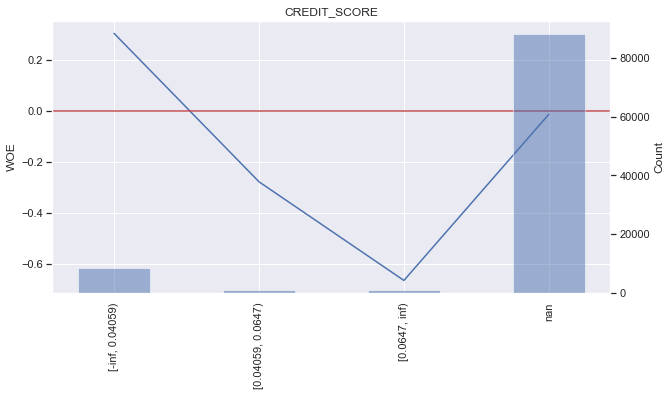

In [43]:
grouping.plot_bins(data=data, cols_pred_num=cols_pred_num, cols_pred_cat=cols_pred_cat,
                    mask=train_mask, col_target=col_target, output_folder=output_folder, col_weight=None)

## Add the transformed variables to the data set

### WOE variables

Add WOE variabes to the data set.

In [44]:
woe_columns_to_replace = list()
for column in data_woe.columns:
    if column in data:
        woe_columns_to_replace.append(column)
        print('Column', column ,'dropped as it already existed in the data set.')
data = data.drop(woe_columns_to_replace, axis='columns')
data = data.join(data_woe)

del data_woe
gc.collect()

print('Added WOE variables. Number of columns:',data.shape[1])
cols_woe = [s + '_WOE' for s in cols_pred]

Added WOE variables. Number of columns: 8


### Dummy variables

**Optional.**

In [45]:
dummy_columns_to_replace = list()
for column in data_dummy.columns:
    if column in data:
        dummy_columns_to_replace.append(column)
        print('Column', column ,'dropped as it already existed in the data set.')
data = data.drop(dummy_columns_to_replace, axis='columns')
data = data.join(data_dummy)

del data_dummy
gc.collect()

print('Added dummy variables. Number of columns:',data.shape[1])

Added dummy variables. Number of columns: 12


#  Feature selection

First remove WOE variables with one WOE value only - they will have no predictive power.

In [46]:
cols_del = list()
for name, column in data[train_mask][cols_woe].iteritems():
    if (column.count() == 0) or (column.max() == column.min()):
        cols_del.append(name)
        cols_woe.remove(name)

if len(cols_del) > 0:
    print('Variables',cols_del,'will not be further used as they have only 1 unique WOE level.')
else:
    print('All predictors have more than 1 unique WOE level.')

All predictors have more than 1 unique WOE level.


## Predictor power analysis

Calculates IV and Gini of each predictor, sorts the predictors by their power. The power is calculated for each of the samples (train, validate, test, OOT, H.OOT). **If one or more of the samples are empty, comment the according part of the code.**

In [47]:
from scoring.metrics import iv,gini,lift

power_tab = []
for j in range(0,len(cols_woe)):
    power_tab.append({'Name':cols_woe[j]
                    ,'IV Train':iv(data.loc[train_mask,col_target],data.loc[train_mask,cols_woe[j]])
                    ,'Gini Train':gini(data.loc[train_mask,col_target],-data.loc[train_mask,cols_woe[j]])
                    ,'IV Validate':iv(data.loc[valid_mask,col_target],data.loc[valid_mask,cols_woe[j]])
                    ,'Gini Validate':gini(data.loc[valid_mask,col_target],-data.loc[valid_mask,cols_woe[j]])
                    ,'IV Test':iv(data.loc[test_mask,col_target],data.loc[test_mask,cols_woe[j]])
                    ,'Gini Test':gini(data.loc[test_mask,col_target],-data.loc[test_mask,cols_woe[j]])
                    ,'IV OOT':iv(data.loc[oot_mask,col_target],data.loc[oot_mask,cols_woe[j]])
                    ,'Gini OOT':gini(data.loc[oot_mask,col_target],-data.loc[oot_mask,cols_woe[j]])
                    ,'IV HOOT':iv(data.loc[hoot_mask,col_target],data.loc[hoot_mask,cols_woe[j]])
                    ,'Gini HOOT':gini(data.loc[hoot_mask,col_target],-data.loc[hoot_mask,cols_woe[j]])
                         })
power_out = pd.DataFrame.from_records(power_tab)
power_out = power_out.set_index('Name')
power_out = power_out.sort_values('Gini Train',ascending=False)

pd.options.display.max_rows = 1000
display(power_out)
pd.options.display.max_rows = 15
power_out.to_csv(output_folder+'/predictors/covariates.csv')

,IV Train,Gini Train,IV Validate,Gini Validate,IV Test,Gini Test,IV OOT,Gini OOT,IV HOOT,Gini HOOT
Name,,,,,,,,,,
CREDIT_SCORE_WOE,0.01568,0.035473,0.021874,0.039633,0.019421,0.039106,0.014583,0.044482,0.002375,0.000553


## Time stability of predictors

### Stability charts

Set metadata for the stability charts. Two types of charts will be drawn:
- Stability of default rate, for which the variables with default and with base need to be set
- Stability of population, for which the variable with observation count needs to be set

In [48]:
target_for_default = col_target
base_for_default = col_base
data['ones'] = 1
obs_for_population = col_base

In [49]:
data.head()

,DATE_DECISION,CREDIT_SCORE,RISK_FSTPD30,BASE,DAY,MONTH,data_type,CREDIT_SCORE_WOE,CREDIT_SCORE_DMY_0,CREDIT_SCORE_DMY_1,CREDIT_SCORE_DMY_2,CREDIT_SCORE_DMY_NaN,ones
SKP_CREDIT_CASE,,,,,,,,,,,,,
249824251,28-08-19,NaN,1.0,1,20190828,201908,hoot,-0.011685,0,0,0,1,1
249824362,28-08-19,NaN,0.0,1,20190828,201908,hoot,-0.011685,0,0,0,1,1
249824367,28-08-19,NaN,0.0,1,20190828,201908,hoot,-0.011685,0,0,0,1,1
249824372,28-08-19,NaN,0.0,1,20190828,201908,hoot,-0.011685,0,0,0,1,1
249824479,28-08-19,NaN,0.0,1,20190828,201908,hoot,-0.011685,0,0,0,1,1


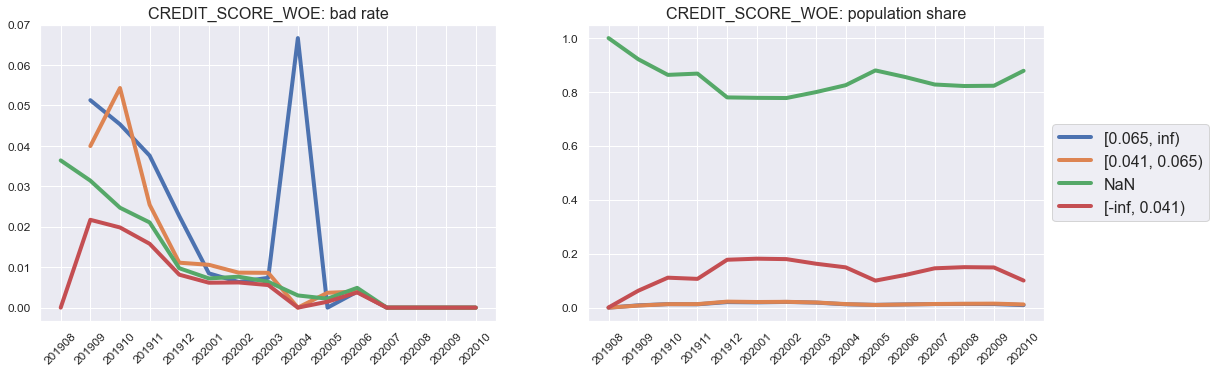

In [50]:
from scoring.plot import stability_chart

# clf = modelSW
list_pred = ['CREDIT_SCORE_WOE']
# for col in list(clf.final_predictors_):
for col in list_pred:
    
    stability_chart(binvar = data[col],
                    target = data[target_for_default],
                    base = data[base_for_default],
                    obs = data[obs_for_population],
                    month = data[col_month],
#                    weight = data[col_weight],
                    grouping=grouping, # comment this out for old plots with WOE values
                    savepath = output_folder+'/stability/'+col+'_')

### Stability Index

The following code calculates two versions of Elena's Stability Index, which are defined as follows.

**v1** 
1. Compute the bad rates in each category for each month
2. Compute the rank of each category within each month based on the bad rate
3. Compute the frequency of each position / rank within each category from step 2
4. Compute the ratios of the most frequent position / rank within each category from step 3
5. Compute average of the ratios from step 4

**v2**
1. Compute the bad rates in each category for each month
2. Compute the rank of each category within each month based on the bad rate
3. Compute the frequency of each position / rank through all categories from step 2 and the corresponding ratios
4. Compute the product of the ratios within each position / rank from step 3
5. Compute average of the products from step 4

*Note: Both version can give "false positives" (indicating that variable is unstable) for U-shaped variables.*

In [51]:
from scoring.stability_index import stability_index_value

stability_tab = []

# for pred in clf.final_predictors_:
for pred in list_pred:

    for mask in ['train_mask', 'valid_mask', 'test_mask', 'oot_mask', 'hoot_mask']:
        for ver in ['v1', 'v2']:
            stability_tab.append({'Name':pred, 'Sample':mask[:-5], 'Index version':ver, 'Index value':
                                 stability_index_value(data[eval(mask)], pred, col_target, col_base, col_month)[ver]})

stability_tab = pd.DataFrame(stability_tab)
stability_tab = stability_tab.groupby(['Name','Index version','Sample'])[['Index value']].mean().unstack(level=[1,2])

pd.options.display.max_rows = 1000
display(stability_tab)
stability_tab.to_csv(output_folder+'/stability/stability_index.csv')

Index value                                                 \
Index version             v1                              v2                  
Sample                  hoot       oot test train valid hoot       oot test   
Name                                                                          
CREDIT_SCORE_WOE         1.0  0.541667  1.0  0.75   1.0  1.0  0.040855  1.0   

                               
Index version                  
Sample            train valid  
Name                           
CREDIT_SCORE_WOE  0.625   1.0

### PSI

In [52]:
from scoring.stability_index import psi_calc_df
monthly_psi, masked_psi = psi_calc_df(data, cols_pred_psi=list_pred, col_month='MONTH')
display(monthly_psi)

There are some different categories in variables sref and sact. They will be ignored in PSI.
Month run: variable CREDIT_SCORE_WOE is proceed. Done variables: 0/0


,Variable,PSI avg per month
0,CREDIT_SCORE_WOE,0.033155
